In [1]:
from google.colab import drive  # 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


#데이터셋 나누기

In [2]:
# 필요 라이브러리 import 
import numpy as np
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision
import time
import copy
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.8.1+cu101].
This notebook use [cuda:0].


In [3]:
EPOCHS = 50
BATCH_SIZE=80
LEARNING_RATE=0.001

In [4]:
from torchvision import datasets, transforms, models

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])])




DATASET_PATH = "/content/drive/MyDrive/생체인증보안/finger2"


train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=transforms)
val_data = datasets.ImageFolder(DATASET_PATH + '/validate', transform=transforms)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_iter = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [5]:
pretrained_model = models.resnet34(pretrained=True)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 8)

pretrained_model = pretrained_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)

In [7]:
total_params = 0
for param_name, param in pretrained_model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 21,288,776


In [8]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        model.eval()
        for batch_img, batch_lab in data_iter:
            X = batch_img.to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

In [9]:
# Training Phase
print_every = 1
print("Start training !")

# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:

        X = batch_img.to(device)
        Y = batch_lab.to(device)
        
        y_pred = pretrained_model.forward(X)
        loss = criterion(y_pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val_sum += loss
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(pretrained_model, val_iter, BATCH_SIZE)
        print(f"epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")

print("Training Done !")

Start training !
epoch:[1/50] cost:[2.426] test_accuracy:[37.500]
epoch:[2/50] cost:[0.368] test_accuracy:[75.000]
epoch:[3/50] cost:[0.033] test_accuracy:[81.250]
epoch:[4/50] cost:[0.006] test_accuracy:[81.250]
epoch:[5/50] cost:[0.016] test_accuracy:[93.750]
epoch:[6/50] cost:[0.004] test_accuracy:[62.500]
epoch:[7/50] cost:[0.003] test_accuracy:[50.000]
epoch:[8/50] cost:[0.013] test_accuracy:[75.000]
epoch:[9/50] cost:[0.002] test_accuracy:[62.500]
epoch:[10/50] cost:[0.002] test_accuracy:[62.500]
epoch:[11/50] cost:[0.002] test_accuracy:[62.500]
epoch:[12/50] cost:[0.002] test_accuracy:[62.500]
epoch:[13/50] cost:[0.002] test_accuracy:[62.500]
epoch:[14/50] cost:[0.001] test_accuracy:[62.500]
epoch:[15/50] cost:[0.001] test_accuracy:[62.500]
epoch:[16/50] cost:[0.001] test_accuracy:[62.500]
epoch:[17/50] cost:[0.001] test_accuracy:[81.250]
epoch:[18/50] cost:[0.001] test_accuracy:[87.500]
epoch:[19/50] cost:[0.000] test_accuracy:[87.500]
epoch:[20/50] cost:[0.000] test_accuracy:[

In [10]:
val_iter = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
data_iter = iter(val_iter)
images, labels = next(data_iter)

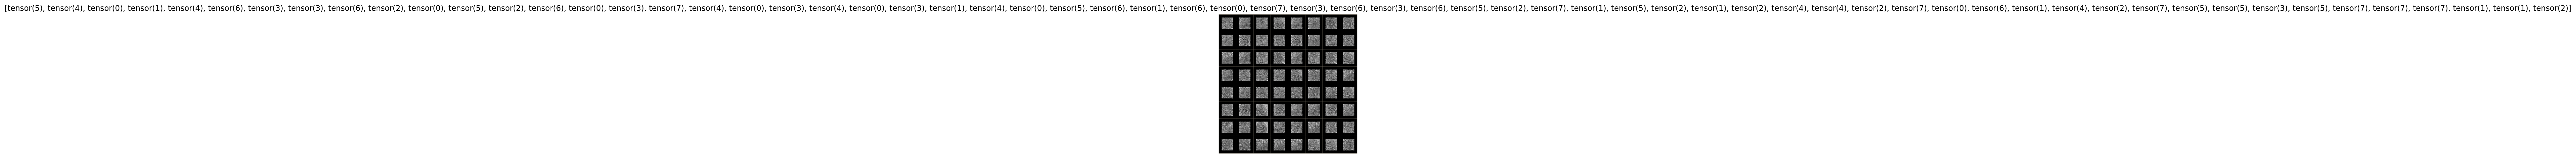

In [11]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)
    return ax
  
inputs, classes = next(iter(train_iter))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

test_accuracy : 1.000


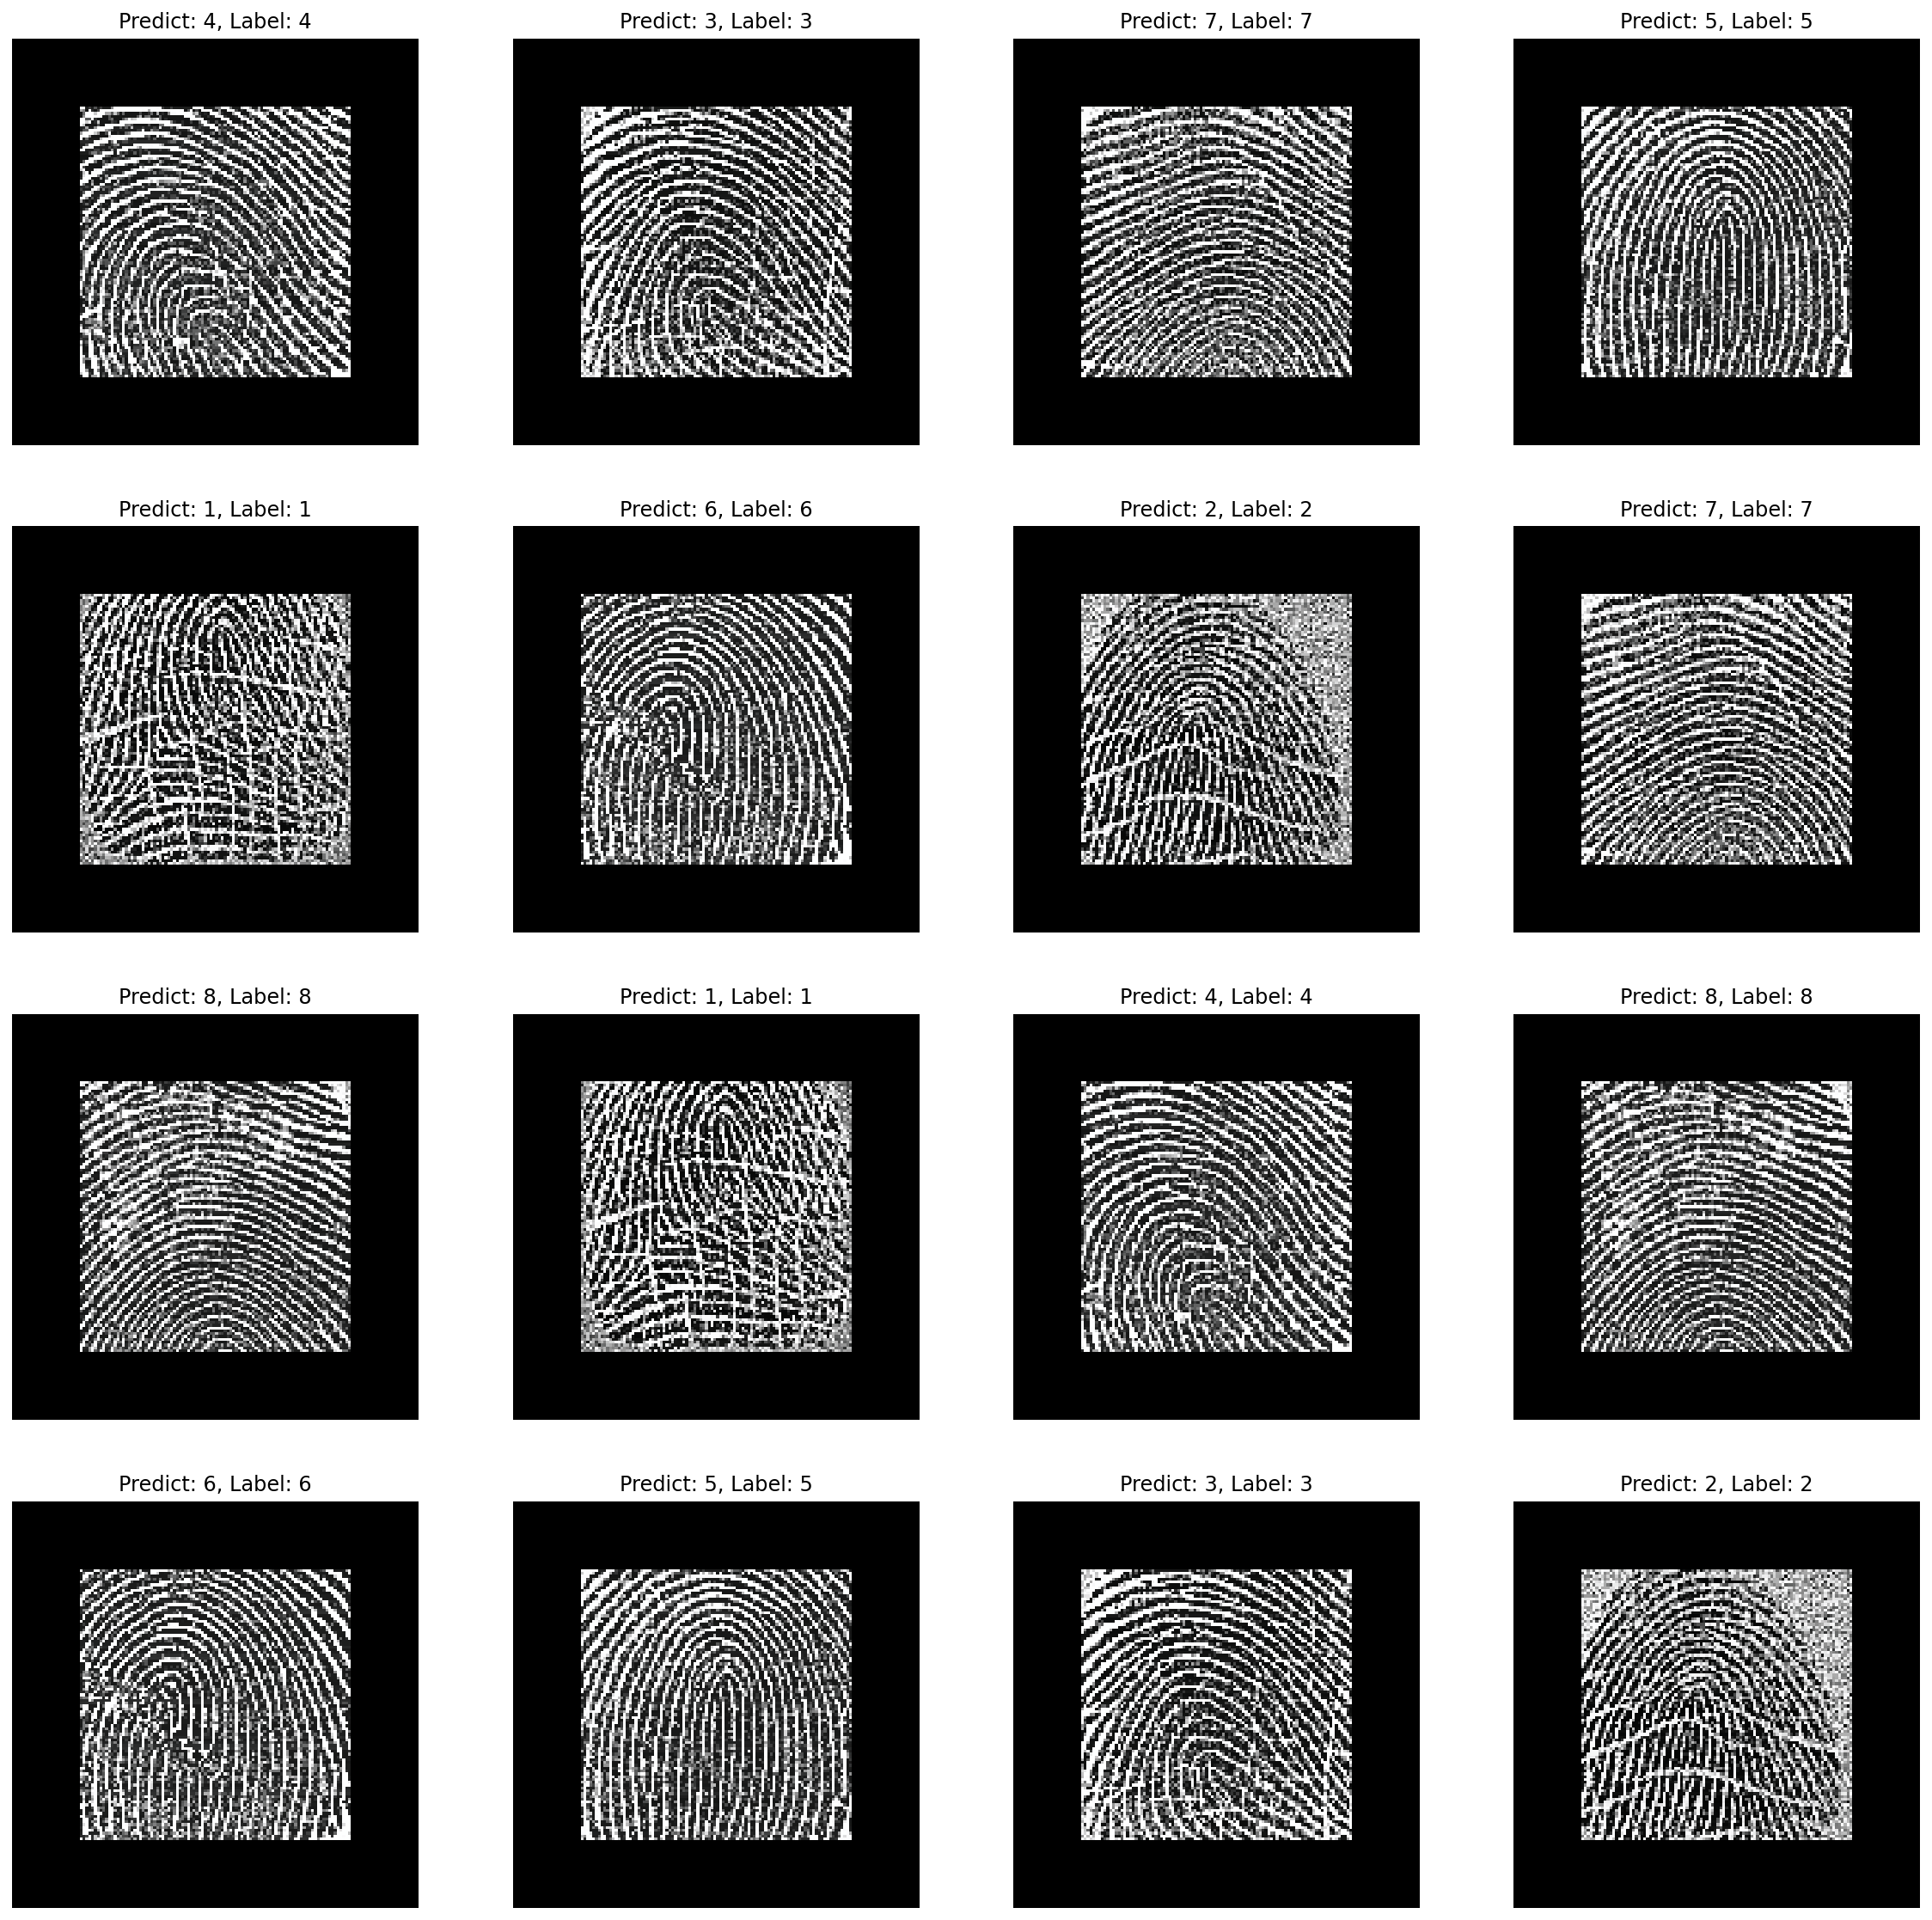

In [12]:
n_sample = 16
test_x = images[:n_sample]
test_y = labels[:n_sample]

with torch.no_grad():
    pretrained_model.eval()
    y_pred = pretrained_model.forward(test_x.type(torch.float).to(device))
    pretrained_model.train()
    
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

test_accuracy = sum([1 for i, j in zip(y_pred, test_y) if i == j]) / n_sample
print(f"test_accuracy : {test_accuracy:.3f}")

for idx in range(n_sample):
    ax = plt.subplot(4, 4, idx+1)
    title = f"Predict: {y_pred[idx]+1}, Label: {test_y[idx]+1}"
    imshow(test_x[idx], ax, title)

plt.show()

#test


In [13]:
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=transforms)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle= False, num_workers=1)

class_name = test_data.classes
class_len = len(class_name)

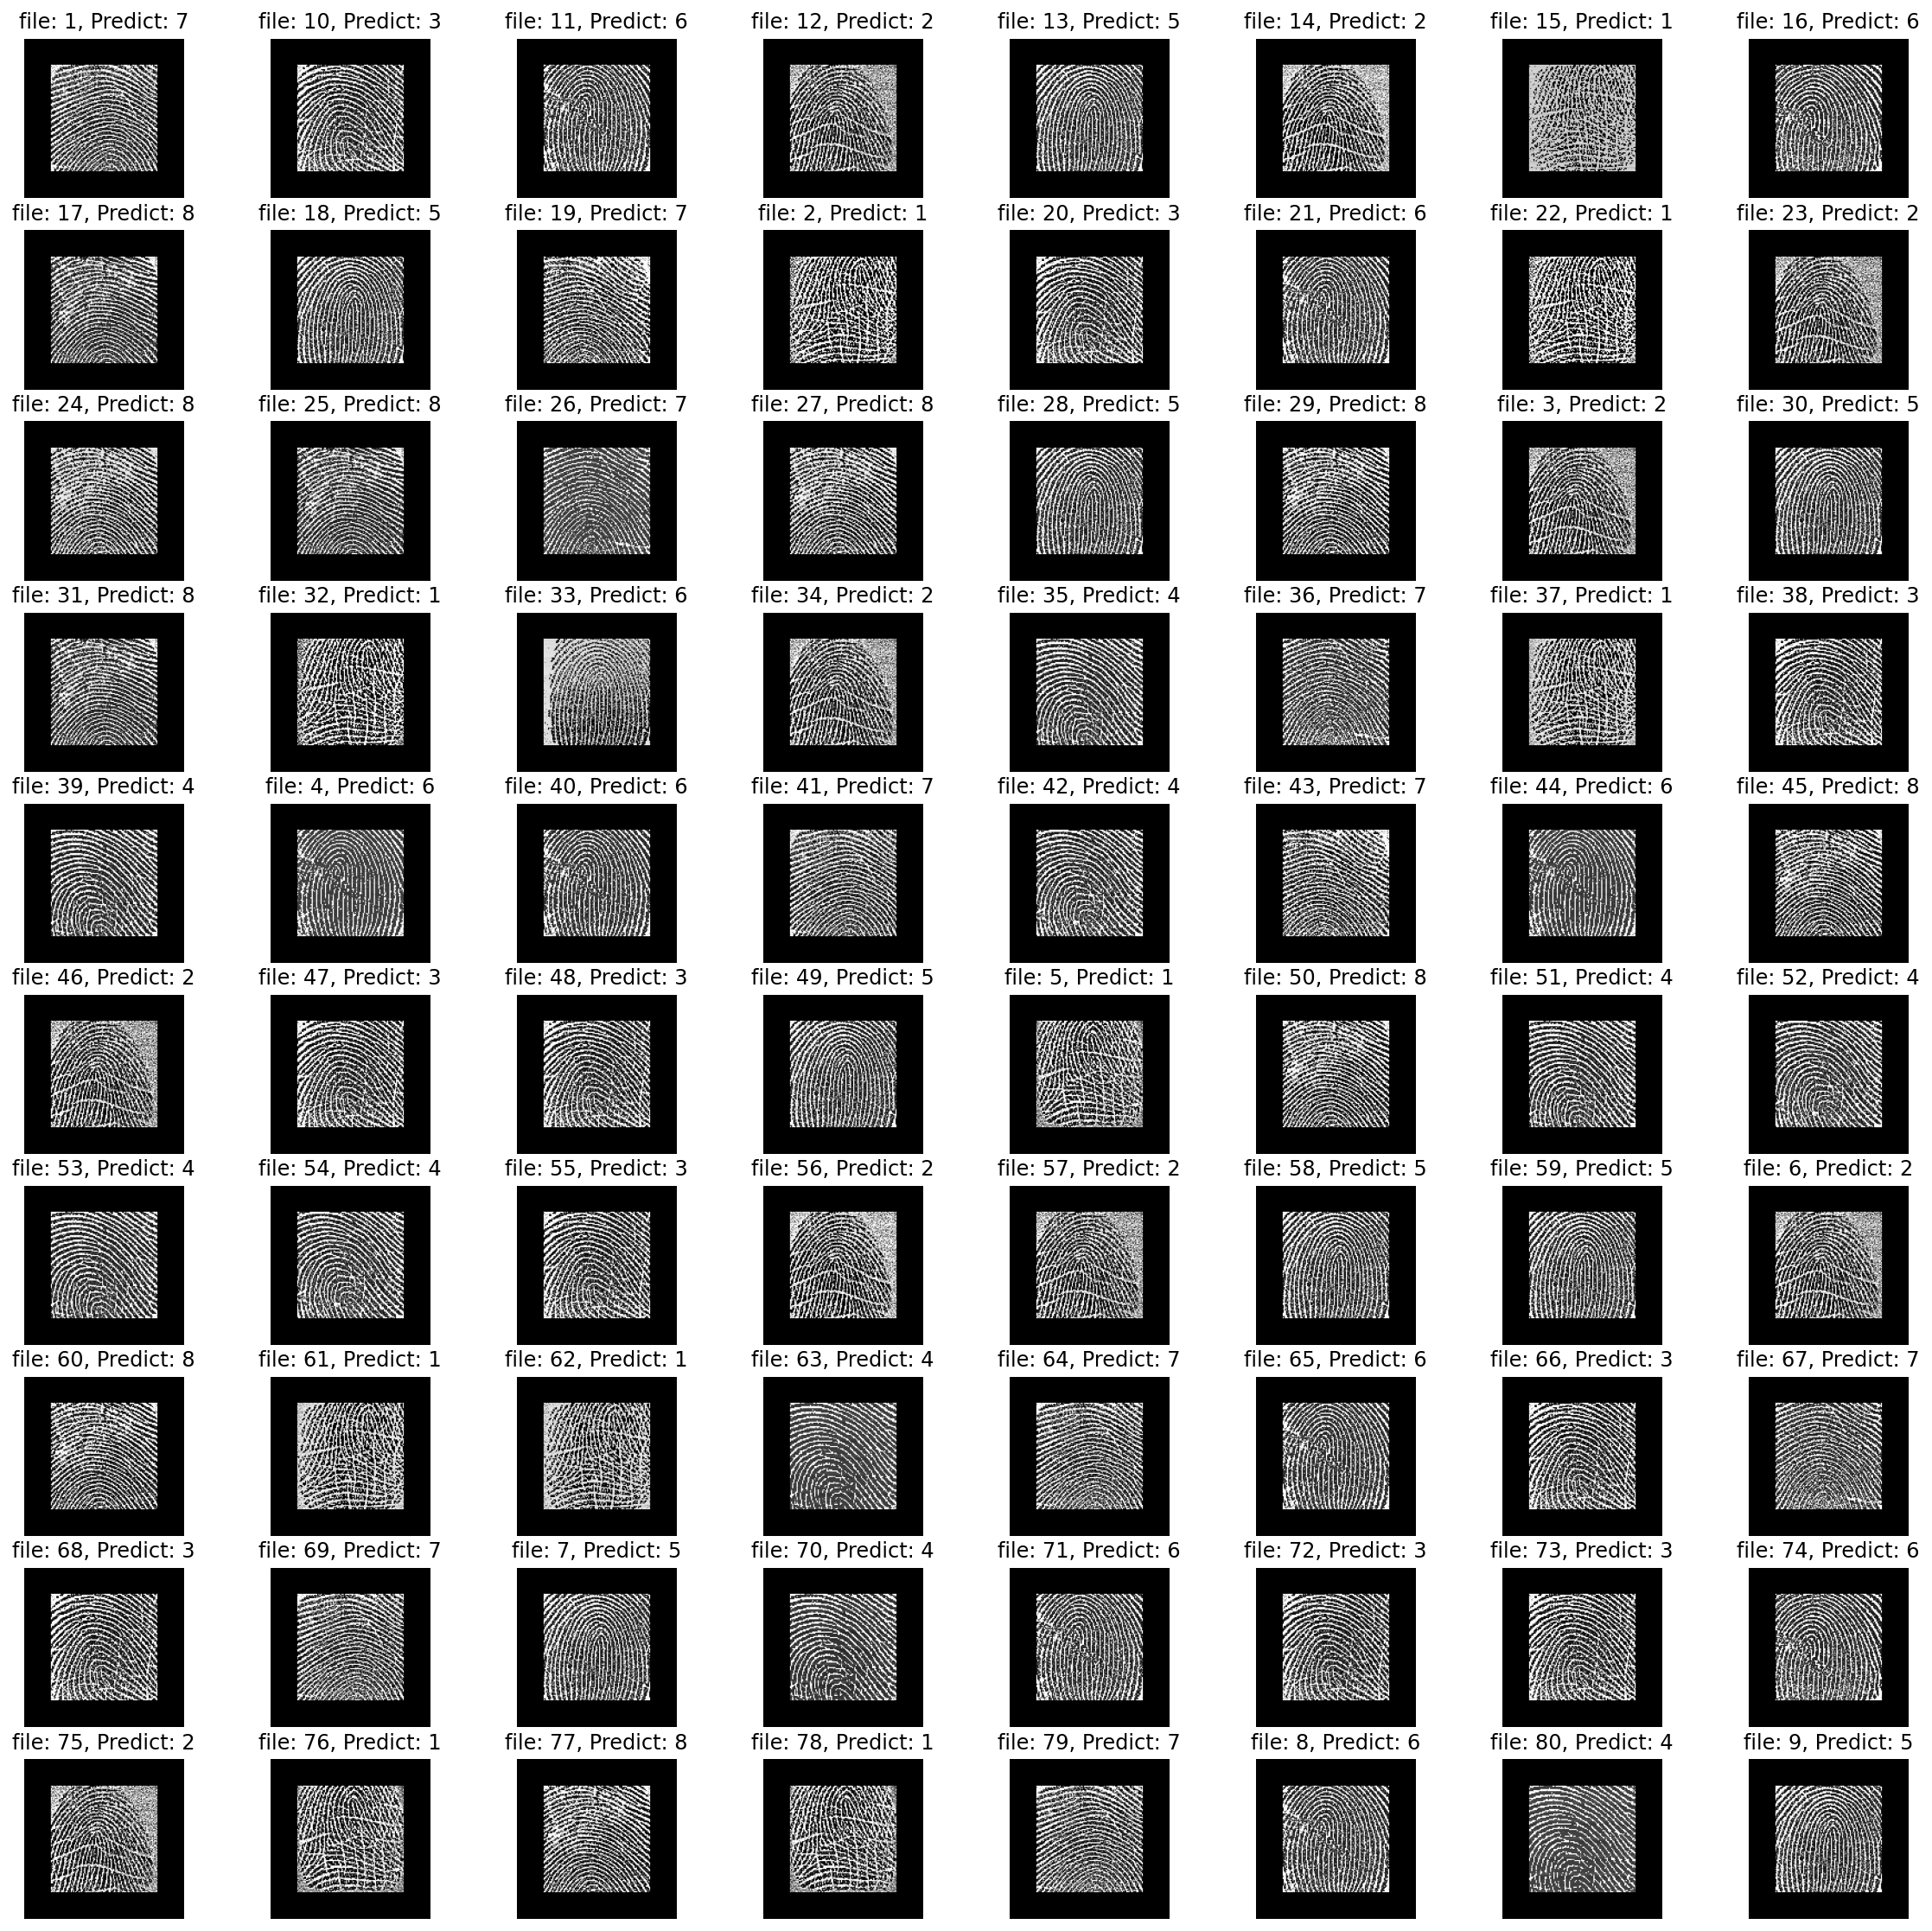

In [14]:
data_iter = iter(test_iter)
images, labels = next(data_iter)

# 라벨링할 class는 train_iter에서
inputs, classes = next(iter(train_iter))
out = torchvision.utils.make_grid(inputs)

n_sample = 80
test_x = images[:n_sample]
test_y = labels[:n_sample]

with torch.no_grad():
    pretrained_model.eval()
    y_pred = pretrained_model.forward(test_x.type(torch.float).to(device))
    pretrained_model.train()
    
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

result= []

for idx in range(n_sample):
    ax = plt.subplot(10, 8, idx+1)
    title = f"file: {class_name[test_y[idx]]}, Predict: {y_pred[idx]+1}"
    result.append({'image':class_name[test_y[idx]], 'answer':y_pred[idx]+1})
    imshow(test_x[idx], ax, title)



plt.show()


In [15]:
from openpyxl import Workbook # 값을 자동으로 엑셀에 저장하는 코드
 
wb = Workbook()

sheet1 = wb.active

sheet1.title = 'sampleSheet'
fname = 'result.xlsx'

n = len(result)

for i in range(n):
  sheet1.cell(row=i+1, column=1).value = result[i].get('image')
  sheet1.cell(row=i+1, column=2).value =  str(result[i].get('answer'))[7]

wb.save(filename=fname)
